# Script use to compute the result of the energy budget paper

The files "objectives.csv" are csv generated by the results.py file.
Interesting part of this notebook:
- Show how to use ggplot2 of R with pandas dataframes
- Give a theme for ggplot2 that behaves well on papers
- Show how to do noramlize traces from different workload/supercomputer.



In [1]:
%matplotlib inline

import pandas as pd

import glob, os, sys

expes = pd.DataFrame()


objs_csv = glob.glob("expes/*/objectives.csv")


for filename in objs_csv:
    
    expe_name = filename.split("/")[1]
    expe_tab = expe_name.split("_")

    expe = {
        "filename": filename,
        "expe_name": expe_name,
        "scheduler": expe_tab[0],
        "trace": expe_tab[-3]+"_"+expe_tab[-2]+"_"+expe_tab[-1]
        }
    if len(expe_tab) >= 8:
        expe["budget_time"] = expe_tab[1]
        expe["budget_percent"] = int(float(expe_tab[2])*100)
        expe["algo"] = expe_tab[3]
        expe["shut"] = expe_tab[4]
    else:
        #expe["budget_time"] = None
        expe["budget_percent"] = 100
        expe["algo"] = "BF"
        expe["shut"] = "IDLE"
    
    expe["cond"] = expe["algo"]+"_"+expe["shut"]
    #if expe["trace"] == "sdscblue_1w_2541605":
    #    continue
    #if expe["budget_percent"] < 40:
    #    continue

    try:
        df = pd.read_csv(os.path.dirname(filename+"/objectives.csv"), sep=" ")
        res = pd.concat([pd.DataFrame([expe]), df], axis=1)

        expes = pd.concat([expes, res])
    except:
        print("error on "+filename)
        continue



In [2]:
if len(expes.nb_jobs.unique()) != len(expes.trace.unique()):
    print(["ERROR!" for i in range(100)])
else:
    print("ok !")
nexpes = len(expes)
nexpes_todo = len(expes.trace.unique())*(len(expes.cond.unique())-1)*len(expes.budget_percent.unique())+\
                len(expes.trace.unique())
if nexpes != nexpes_todo:
    print (str(nexpes_todo-nexpes)+" expes miss !")
    for i in expes.expe_name:
        print(i)


expes.columns

ok !


Index(['algo', 'avgbsld', 'budget_percent', 'budget_time', 'cond', 'ctime',
       'energyBudget', 'energyTot', 'energyWeek', 'expe_name', 'filename',
       'jobRun', 'jobRunWithEnd', 'maxbsld', 'nb_jobs', 'scheduler', 'shut',
       'trace', 'util'],
      dtype='object')

In [3]:
import uuid
from rpy2.robjects.packages import importr 
from IPython.core.display import Image
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects
import rpy2.robjects as ro
pandas2ri.activate()

grdevices = importr('grDevices')
def ggplot_notebook(gg, width = 800, height = 600):
    fn = 'toRM_{uuid}.png'.format(uuid = uuid.uuid4())
    grdevices.png(fn, width = width, height = height)
    gg.plot()
    grdevices.dev_off()
    return Image(filename=fn)
def ggplot_pdf(gg, filename, width = 7, height = 7):
    grdevices.pdf(filename, width = width, height = height)
    gg.plot()
    grdevices.dev_off()



from rpy2.robjects.lib import ggplot2
from rpy2.robjects import Formula

theme_bwTUNED = {
		"plot.title" : ggplot2.element_text(face="bold", size=14),
		"axis.title.x": ggplot2.element_text(face="bold", size=14),
		"axis.title.y": ggplot2.element_text(face="bold", size=14, angle=90),
		"axis.text.x" : ggplot2.element_text(size=10),
		"axis.text.y" : ggplot2.element_text(size=10),
		"panel.grid.minor" : ggplot2.element_blank(),
		"legend.key" : ggplot2.element_rect(colour="white")}

In [4]:

#expes.loc[:,"cond"] = expes.apply(lambda row: ("rPC" if row.reducePC == "True" else "ene")+"_"+("steal" if row.allowBudgetStealing == "True"  else "NOsteal") ,axis=1)
#expes.loc[:,"cond"] = expes.apply(lambda row: "NA" if pd.isnull(row.reducePC) else row["cond"] ,axis=1)

expes['jobRunWithEndRel'] = expes['jobRunWithEnd']/expes['nb_jobs']


#TO RENAME EXPERIMENTAL CONDITIONS: USE A NEW COLUMN, BECAUSE SOME USE "cond" AS SOMETHING IMPOTANT
#expes.loc[expes.cond == "energyBud_SHUT", ("condBeautiful")] = "NEW NAME"


expes.loc[pd.isnull(expes.budget_percent), ("budget_percent")] = 100

expes = expes[pd.notnull(expes['ctime'])]
expes.head()

,algo,avgbsld,budget_percent,budget_time,cond,ctime,energyBudget,energyTot,energyWeek,expe_name,filename,jobRun,jobRunWithEnd,maxbsld,nb_jobs,scheduler,shut,trace,util,jobRunWithEndRel
0,energyBud,227.012506,100,3dMid,energyBud_IDLE,2846196.00,1.607149e+11,1.168196e+12,3.721657e+11,easyEnergyBudget_3dMid_1.0_energyBud_IDLE_meta...,expes/easyEnergyBudget_3dMid_1.0_energyBud_IDL...,34930,35281.956070,22159.990,35604,easyEnergyBudget,IDLE,metacentrum_1w_1362700000,0.923232,0.990955
0,reducePC,524.931081,70,3dMid,reducePC_IDLE,817201.00,2.950831e+12,1.017526e+13,7.517482e+12,easyEnergyBudget_3dMid_0.7_reducePC_IDLE_curie...,expes/easyEnergyBudget_3dMid_0.7_reducePC_IDLE...,10077,10116.527903,22207.700,10217,easyEnergyBudget,IDLE,curie_1w_48889200,0.618349,0.990166
0,energyBud,617.846987,80,3dMid,energyBud_SHUT,3111073.52,1.352570e+11,1.230308e+12,3.412960e+11,easyEnergyBudget_3dMid_0.8_energyBud_SHUT_meta...,expes/easyEnergyBudget_3dMid_0.8_energyBud_SHU...,20861,21343.964240,29487.804,26958,easyEnergyBudget,SHUT,metacentrum_1w_1363658910,0.837402,0.791749
0,energyBud,2024.833192,30,3dMid,energyBud_SHUT,3410127.04,5.231258e+10,1.291010e+12,2.391195e+11,easyEnergyBudget_3dMid_0.3_energyBud_SHUT_meta...,expes/easyEnergyBudget_3dMid_0.3_energyBud_SHU...,15993,16534.117106,64513.952,26958,easyEnergyBudget,SHUT,metacentrum_1w_1363658910,0.511500,0.613329
0,reducePC,161.102344,90,3dMid,reducePC_SHUT,3170842.00,1.449262e+11,1.252843e+12,3.388477e+11,easyEnergyBudget_3dMid_0.9_reducePC_SHUT_metac...,expes/easyEnergyBudget_3dMid_0.9_reducePC_SHUT...,19517,19750.335602,10084.224,20283,easyEnergyBudget,SHUT,metacentrum_1w_1360041254,0.806400,0.973738


In [5]:
nodesN = {'curie_1w_43659000':80640,
'curie_1w_46054648':80640,
'curie_1w_47096700':80640,
'curie_1w_47701500':80640,
'curie_1w_48889200':80640,
'curie_1w_48911100':80640,
'curie_1w_50027000':80640,
'curie_1w_50695174':80640,
'curie_1w_51391610':80640,
'curie_1w_51996500':80640,
'metacentrum_1w_1360041254':3356,
'metacentrum_1w_1360702000':3356,
'metacentrum_1w_1361306800':3356,
'metacentrum_1w_1362000000':3356,
'metacentrum_1w_1362700000':3356,
'metacentrum_1w_1363178104':3356,
'metacentrum_1w_1363658910':3356,
'metacentrum_1w_1366230000':3356,
'metacentrum_1w_1367276567':3356,
'metacentrum_1w_1368609388':3356,
'sdscblue_1w_10166421':1152,
'sdscblue_1w_16944036':1152,
'sdscblue_1w_22874448':1152,
'sdscblue_1w_2541605':1152,
'sdscblue_1w_30499265':1152,
'sdscblue_1w_36029677':1152,
'sdscblue_1w_43207292':1152,
'sdscblue_1w_47443301':1152,
'sdscblue_1w_5063210':1152,
'sdscblue_1w_61845732':1152}
PowerComputeReal = 190.738
#PowerComputeUser = 203.12
expes["eneWAvail"] = [ nodesN[t]*3600.*24.*7. for t in expes.trace]

expes["eneWAvail"] = ( expes["budget_percent"] /100.0* 3./7.*PowerComputeReal + PowerComputeReal*4./7.)*expes["eneWAvail"]


expes["eneWCons"] = expes["energyWeek"] / expes["eneWAvail"]
expes[["trace", "cond",  "budget_percent", "energyBudget",
       "energyWeek",   "eneWAvail", "eneWCons"]].head(10)

,trace,cond,budget_percent,energyBudget,energyWeek,eneWAvail,eneWCons
0,metacentrum_1w_1362700000,energyBud_IDLE,100,1.607149e+11,3.721657e+11,3.871426e+11,0.961314
0,curie_1w_48889200,reducePC_IDLE,70,2.950831e+12,7.517482e+12,8.106461e+12,0.927344
0,metacentrum_1w_1363658910,energyBud_SHUT,80,1.352570e+11,3.412960e+11,3.539589e+11,0.964225
0,metacentrum_1w_1363658910,energyBud_SHUT,30,5.231258e+10,2.391195e+11,2.709998e+11,0.882360
0,metacentrum_1w_1360041254,reducePC_SHUT,90,1.449262e+11,3.388477e+11,3.705508e+11,0.914443
0,sdscblue_1w_30499265,energyBud_SHUT,70,4.087962e+10,1.125269e+11,1.158066e+11,0.971679
0,metacentrum_1w_1366230000,PC_SHUT,50,1.082869e+10,2.007201e+11,3.041835e+11,0.659865
0,sdscblue_1w_16944036,energyBud_SHUT,60,3.428870e+10,1.035843e+11,1.101112e+11,0.940725
0,sdscblue_1w_43207292,PC_IDLE,49,2.836685e+10,9.478346e+10,1.038462e+11,0.912729
0,curie_1w_51996500,PC_SHUT,49,2.038376e+11,5.269871e+12,7.269237e+12,0.724955


0    5.570420e+12
Name: energyWeek, dtype: float64 0    0.855442
Name: eneWCons, dtype: float64
0    5.744432e+12
Name: energyWeek, dtype: float64 0    0.882164
Name: eneWCons, dtype: float64


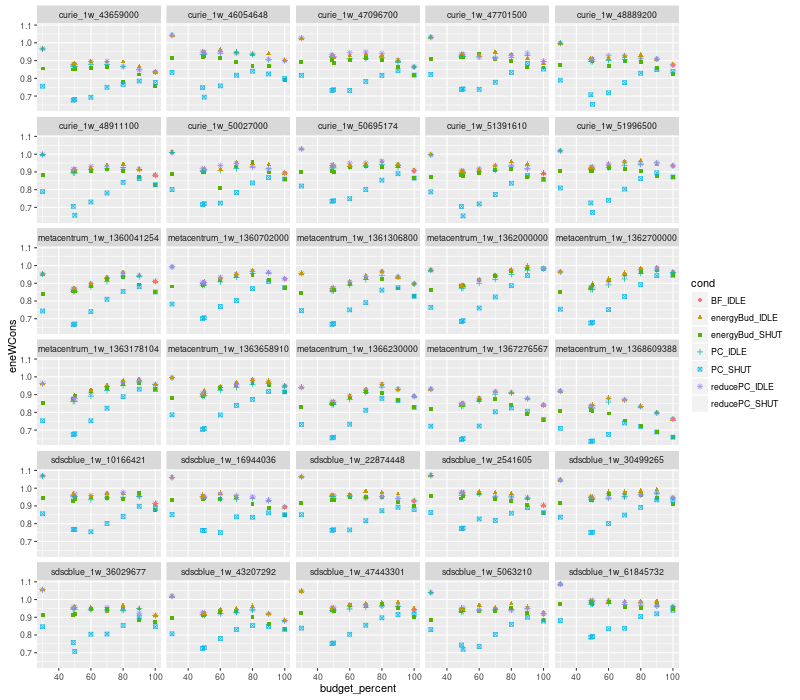

In [6]:

obj = 'eneWCons'

temp = expes[expes.filename == "expes/easyEnergyBudget_3dMid_0.3_energyBud_SHUT_curie_1w_43659000/objectives.csv"]
print (temp["energyWeek"], temp["eneWCons"])
temp = expes[expes.filename == "expes/easyEnergyBudget_3dMid_0.3_energyBud_SHUT_curie_1w_48911100/objectives.csv"]
print (temp["energyWeek"], temp["eneWCons"])

temp = expes#[expes.cond=="energyBud_SHUT"]
#temp = temp[temp.trace == "metacentrum_1w_1361306800"]

p = ggplot2.ggplot(temp) + \
    ggplot2.aes_string(x='budget_percent', y=obj,
                       color='cond', shape='cond', linetype='cond') + \
    ggplot2.geom_point() +ggplot2.facet_wrap("trace", ncol=5)

ggplot_notebook(p, height=700)

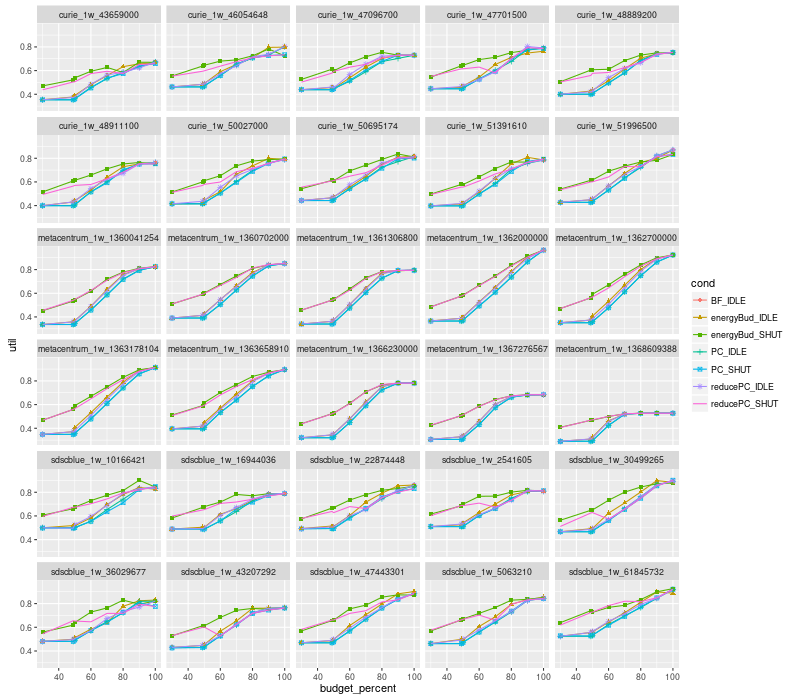

In [7]:


obj = 'util'
p = ggplot2.ggplot(expes) + \
    ggplot2.aes_string(x='budget_percent', y=obj, color='cond', shape='cond') + \
    ggplot2.geom_point() + ggplot2.geom_line()+ggplot2.facet_wrap("trace", ncol=5)

ggplot_notebook(p, height=700)


In [8]:

#a = expes#[expes.budget_percent <= 1.0]
#a = a.append(expes[expes.scheduler == 'easyBackfill'])
easy = expes[expes.scheduler == 'easyBackfill']
objectives = ['ctime', 'util', 'avgbsld', 'maxbsld', 'energyWeek', 'energyBudget', 'eneWCons', "jobRunWithEndRel"]
for obj in objectives:
    for trace in expes.trace.unique():
        mmmax = easy[easy.trace == trace][obj].max()
        expes.loc[expes.trace == trace, obj+"_p"] = expes[expes.trace == trace][obj]/mmmax

easy = expes[expes.cond == "PC_IDLE"]
objectives = ['ctime', 'util', 'avgbsld', 'maxbsld', 'energyWeek', 'energyBudget', 'eneWCons', "jobRunWithEndRel"]
for obj in objectives:
    for trace in expes.trace.unique():
        temp = easy[easy.trace == trace]
        for budget in expes.budget_percent.unique():
            mmmax = temp[temp.budget_percent == budget][obj].max()
            expes.loc[(expes.trace == trace) & (expes.budget_percent == budget), obj+"_m"] =\
                expes[(expes.trace == trace) & (expes.budget_percent == budget)][obj] - mmmax
        
        
        
        
        
for obj in objectives:
    globmean = expes[obj].mean()
    globstd =  expes[obj].std()
    for trace in expes.trace.unique():
        mean = expes[expes.trace == trace][obj].mean()
        std = expes[expes.trace == trace][obj].std()
        expes.loc[expes.trace == trace, obj+"_h"] = globstd/std*(expes[expes.trace == trace][obj]-mean)+globmean
         
        
        
#expes = a#[expes.shut != "SHUT"]
print (expes.columns)



Index(['algo', 'avgbsld', 'budget_percent', 'budget_time', 'cond', 'ctime',
       'energyBudget', 'energyTot', 'energyWeek', 'expe_name', 'filename',
       'jobRun', 'jobRunWithEnd', 'maxbsld', 'nb_jobs', 'scheduler', 'shut',
       'trace', 'util', 'jobRunWithEndRel', 'eneWAvail', 'eneWCons', 'ctime_p',
       'util_p', 'avgbsld_p', 'maxbsld_p', 'energyWeek_p', 'energyBudget_p',
       'eneWCons_p', 'jobRunWithEndRel_p', 'ctime_m', 'util_m', 'avgbsld_m',
       'maxbsld_m', 'energyWeek_m', 'energyBudget_m', 'eneWCons_m',
       'jobRunWithEndRel_m', 'ctime_h', 'util_h', 'avgbsld_h', 'maxbsld_h',
       'energyWeek_h', 'energyBudget_h', 'eneWCons_h', 'jobRunWithEndRel_h'],
      dtype='object')


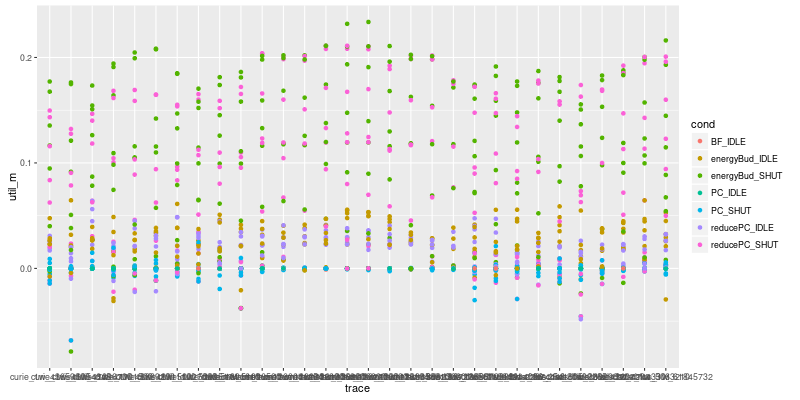

In [9]:
obj = 'util'

p = ggplot2.ggplot(expes) + \
    ggplot2.aes_string(x='trace', y=obj+"_m", color="cond") + \
    ggplot2.geom_point()#+ggplot2.facet_wrap("budget_percent", ncol=1)


ggplot_notebook(p, height=400)
#ggplot_notebook(p, height=400, width=1000)

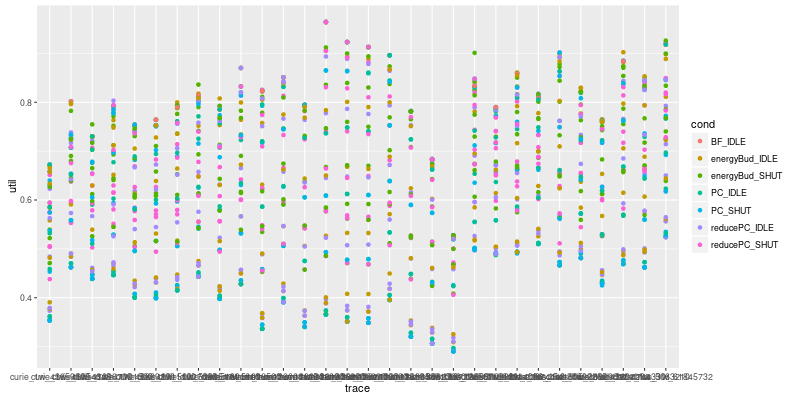

In [10]:
q = ggplot2.ggplot(expes) + \
    ggplot2.aes_string(x='trace', y=obj+"", color="cond") + \
    ggplot2.geom_point()


ggplot_notebook(q, height=400)
#ggplot_notebook(p, height=400, width=1000)

In [11]:


import scipy as sp
from scipy.stats import t
import numpy as np

#from: http://www.cookbook-r.com/Graphs/Plotting_means_and_error_bars_%28ggplot2%29/
## Gives count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   conf_interval: the percent range of the confidence interval (default is 95%)
def summarySE(data, measurevar, groupvars, conf_interval=0.95):
    def std(s):
        return np.std(s, ddof=1)
    def stde(s):
        return std(s) / np.sqrt(len(s))

    def ci(s):
        # Confidence interval multiplier for standard error
        # Calculate t-statistic for confidence interval: 
        # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
        ciMult = t.ppf(conf_interval/2.0 + .5, len(s)-1)
        return stde(s)*ciMult
    def ciUp(s):
        return np.mean(s)+ci(s)
    def ciDown(s):
        return np.mean(s)-ci(s)
    
    data = data[groupvars+measurevar].groupby(groupvars).agg([len, np.mean, std, stde, ciUp, ciDown, ci])

    data.reset_index(inplace=True)


    data.columns = groupvars+ ['_'.join(col).strip() for col in data.columns.values[len(groupvars):]]

    return data


#from: http://www.cookbook-r.com/Graphs/Plotting_means_and_error_bars_%28ggplot2%29/
## Norms the data within specified groups in a data frame; it normalizes each
## subject (identified by idvar) so that they have the same mean, within each group
## specified by betweenvars.
##   data: a data frame.
##   idvar: the name of a column that identifies each subject (or matched subjects)
##   measurevar: the name of a column that contains the variable to be summariezed
##   betweenvars: a vector containing names of columns that are between-subjects variables
def normDataWithin(data, idvar, measurevar, betweenvars=[]):
    def std(s):
        return np.std(s, ddof=1)

    #temp = data[data.cond == "PC_IDLE"]
    #temp = temp[idvar+betweenvars+measurevar]
    #temp.columns = idvar+betweenvars + [x+"_PC_IDLE" for x in measurevar]

    data_subjMean = data.groupby(idvar+betweenvars).agg([np.mean])
    data_subjMean.reset_index(inplace=True)
    data_subjMean.columns = idvar+betweenvars + ['_'.join(col).strip() for col in data_subjMean.columns.values[len(idvar+betweenvars):]]

    data = pd.merge(data, data_subjMean, on=idvar+betweenvars)
    #data = pd.merge(data, temp, on=idvar+betweenvars)

    for obj in measurevar:
        data[obj+"_norm"] = data[obj] - data[obj+"_mean"] + data[obj].mean()
        #data[obj+"_norm"] = std(data[obj])/data[obj+"_std"]*(data[obj] - data[obj+"_mean"]) + data[obj].mean()
        #data[obj+"_norm"] = data[obj] - data[obj+"_PC_IDLE"]
        #del data[obj+"_mean"]
        #del data[obj+"_std"]
    
    return data



#from: http://www.cookbook-r.com/Graphs/Plotting_means_and_error_bars_%28ggplot2%29/
## Summarizes data, handling within-subjects variables by removing inter-subject variability.
## It will still work if there are no within-S variables.
## Gives count, un-normed mean, normed mean (with same between-group mean),
##   standard deviation, standard error of the mean, and confidence interval.
## If there are within-subject variables, calculate adjusted values using method from Morey (2008).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   betweenvars: a vector containing names of columns that are between-subjects variables
##   withinvars: a vector containing names of columns that are within-subjects variables
##   idvar: the name of a column that identifies each subject (or matched subjects)
##   conf_interval: the percent range of the confidence interval (default is 95%)
def summarySEwithin(data, measurevar, betweenvars=[], withinvars=[], idvar=[], conf_interval=.95):
    # Get the means from the un-normed data
    datac = summarySE(data, measurevar, groupvars=betweenvars+withinvars, conf_interval=conf_interval)
    for e in measurevar:
        del datac[e+"_std"]
        del datac[e+"_stde"]
        del datac[e+"_ci"]
        del datac[e+"_ciUp"]
        del datac[e+"_ciDown"]

    # Norm each subject's data
    ndata = normDataWithin(data, idvar, measurevar, betweenvars)

    # This is the name of the new columns
    measurevar_n = [x+"_norm" for x in measurevar]+measurevar
    
    # Collapse the normed data - now we can treat between and within vars the same
    ndatac = summarySE(ndata, measurevar_n, groupvars=betweenvars+withinvars,
                      conf_interval=conf_interval)
    # Apply correction from Morey (2008) to the standard error and confidence interval
    #  Get the product of the number of conditions of within-S variables
    nWithinGroups = 1
    for v in withinvars:
        nWithinGroups = nWithinGroups*len(ndatac[v].unique())
    correctionFactor = np.sqrt( nWithinGroups / (nWithinGroups-1) )
    
    # Apply the correction factor
    for m in measurevar_n:
        ndatac[m+"_std"] = ndatac[m+"_std"] * correctionFactor
        ndatac[m+"_stde"] = ndatac[m+"_stde"] * correctionFactor
        ndatac[m+"_ci"] = ndatac[m+"_ci"] * correctionFactor
    
    return ndatac






expes2 = expes.copy()#[expes.shut != "SHUT"]
#expes2 = expes2[expes2.scheduler == "easyEnergyBudget"]

objectives = ['ctime', 'util', 'avgbsld', 'maxbsld', 'energyWeek', 'energyBudget', 'eneWCons', "jobRunWithEndRel"]
objectives += ['ctime_m', 'util_m', 'avgbsld_m', 'maxbsld_m', 'energyWeek_m', 'energyBudget_m', 'eneWCons_m', "jobRunWithEndRel_m"]
objectives += ['util_p', 'avgbsld_p']

res = summarySEwithin(expes2, measurevar=objectives,
                         withinvars=["cond", "budget_percent"], idvar=["trace"], conf_interval=.95)


res.head()

print (res.cond.unique())


['BF_IDLE' 'PC_IDLE' 'PC_SHUT' 'energyBud_IDLE' 'energyBud_SHUT'
 'reducePC_IDLE' 'reducePC_SHUT']


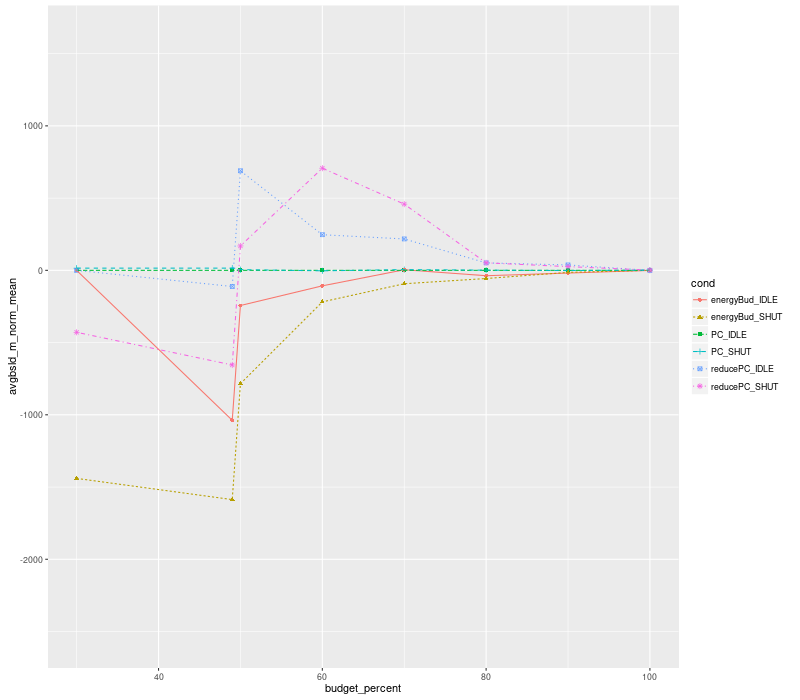

In [12]:

obj = 'avgbsld_m'

p = ggplot2.ggplot(res[res.cond != "BF_IDLE"]) + \
    ggplot2.aes_string(x='budget_percent', y=obj+"_norm_mean",
                       ymax=obj+"_norm_ciUp", ymin=obj+"_norm_ciDown", color='cond', shape='cond', linetype='cond') + \
    ggplot2.geom_point() + ggplot2.geom_line()#+ ggplot2.geom_errorbar()

ggplot_notebook(p, height=700)


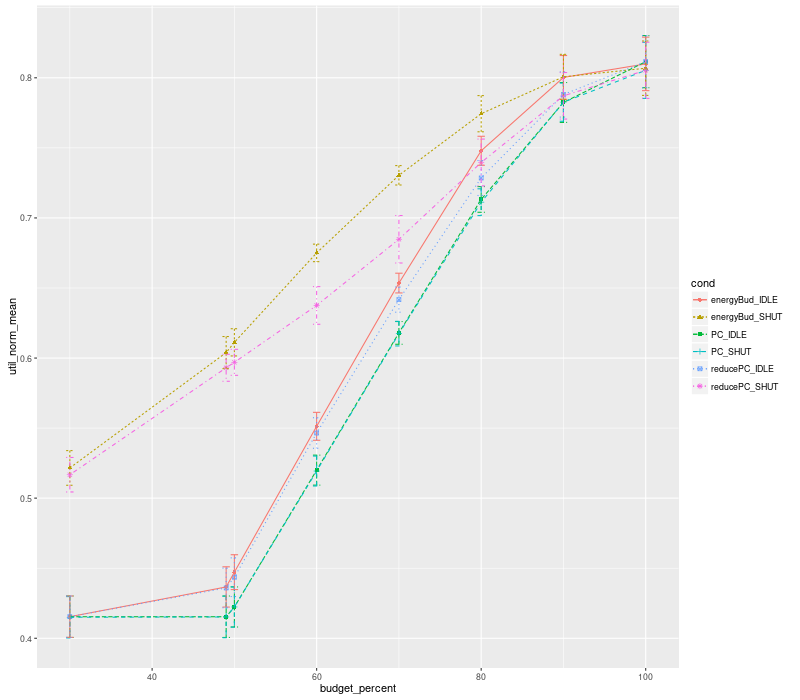

In [13]:

obj = 'util'

p = ggplot2.ggplot(res[res.cond != "BF_IDLE"]) + \
    ggplot2.aes_string(x='budget_percent', y=obj+"_norm_mean",
                       ymax=obj+"_norm_ciUp", ymin=obj+"_norm_ciDown",
                       color='cond', shape='cond', linetype='cond') + \
    ggplot2.geom_point() + ggplot2.geom_line()+ ggplot2.geom_errorbar()

ggplot_notebook(p, height=700)



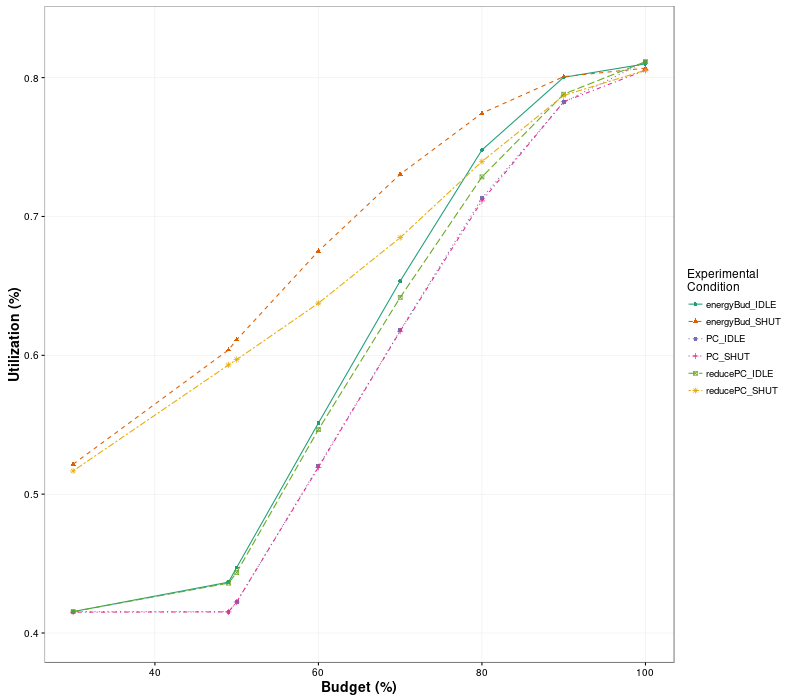

In [14]:
obj = 'util'
    
p = ggplot2.ggplot(res[res.cond != "BF_IDLE"]) + \
    ggplot2.aes_string(x='budget_percent', y=obj+"_norm_mean",
                       ymax=obj+"_norm_ciUp", ymin=obj+"_norm_ciDown",
                       color='cond', shape='cond', linetype='cond') + \
    ggplot2.geom_point() + ggplot2.geom_line()+\
    ggplot2.theme_bw()+ggplot2.theme(**theme_bwTUNED)+ggplot2.labs(x="Budget (%)", y="Utilization (%)")+\
    ggplot2.scale_colour_brewer(name="Experimental\nCondition", palette = "Dark2")+ggplot2.scale_shape(name = "Experimental\nCondition")+\
    ggplot2.scale_linetype_manual(name="Experimental\nCondition",values=robjects.IntVector(range(1,7)))#ggplot2.geom_errorbar()+

ggplot_pdf(p, "util.pdf", 7, 5)
ggplot_notebook(p, height=700)

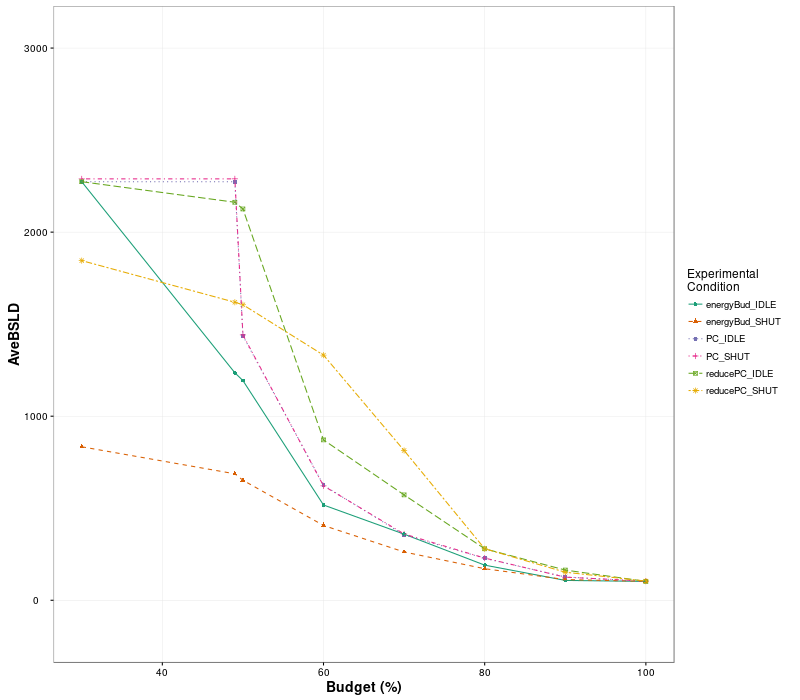

In [15]:

obj = 'avgbsld'

p = ggplot2.ggplot(res[res.cond != "BF_IDLE"]) + \
    ggplot2.aes_string(x='budget_percent', y=obj+"_norm_mean",
                       ymax=obj+"_norm_ciUp", ymin=obj+"_norm_ciDown",
                       color='cond', shape='cond', linetype='cond') + \
    ggplot2.geom_point() + ggplot2.geom_line()+\
    ggplot2.theme_bw()+ggplot2.theme(**theme_bwTUNED)+ggplot2.labs(x="Budget (%)", y="AveBSLD")+\
    ggplot2.scale_colour_brewer(name="Experimental\nCondition", palette = "Dark2")+ggplot2.scale_shape(name = "Experimental\nCondition")+\
    ggplot2.scale_linetype_manual(name="Experimental\nCondition",values=robjects.IntVector(range(1,7)))#+ggplot2.geom_errorbar()

ggplot_pdf(p, "avgbsld.pdf", 7, 5)
ggplot_notebook(p, height=700)

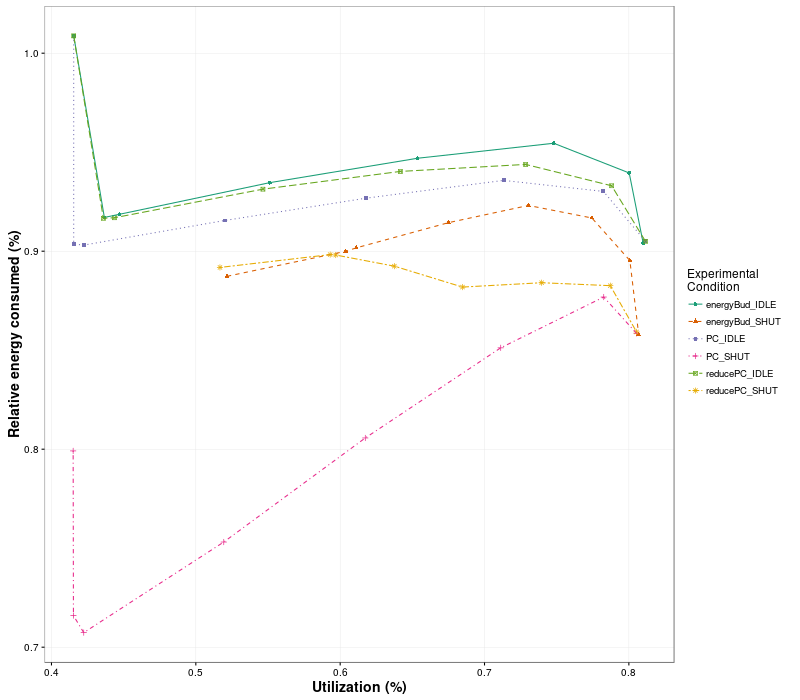

In [16]:
#for i in res.columns:
#    print i

obj1 = 'util'
#obj1 = 'avgbsld'
#obj2 = 'energyWeek'
obj2 = 'eneWCons'

p = ggplot2.ggplot(res[res.cond != "BF_IDLE"]) + \
    ggplot2.aes_string(x=obj1+"_norm_mean", y=obj2+"_norm_mean", label="budget_percent",
                       color='cond', shape='cond', linetype='cond') + \
    ggplot2.geom_point()+ggplot2.geom_line()+\
    ggplot2.theme_bw()+ggplot2.theme(**theme_bwTUNED)+ggplot2.labs(x="Utilization (%)", y="Relative energy consumed (%)")+\
    ggplot2.scale_colour_brewer(name="Experimental\nCondition", palette = "Dark2")+ggplot2.scale_shape(name = "Experimental\nCondition")+\
    ggplot2.scale_linetype_manual(name="Experimental\nCondition",values=robjects.IntVector(range(1,7)))
#    ggplot2.scale_y_reverse()+ ggplot2.scale_x_reverse()+\ ggplot2.geom_text()+

    
q = ggplot2.ggplot(expes) + \
    ggplot2.aes_string(x=obj1, y=obj2,
                       color='cond', linetype='cond') + \
    ggplot2.geom_point()+\
    ggplot2.scale_y_reverse()+ ggplot2.scale_x_reverse()



    
ggplot_pdf(p, "eneWCons_v_util.pdf", 7, 5)
ggplot_notebook(p, height=700)

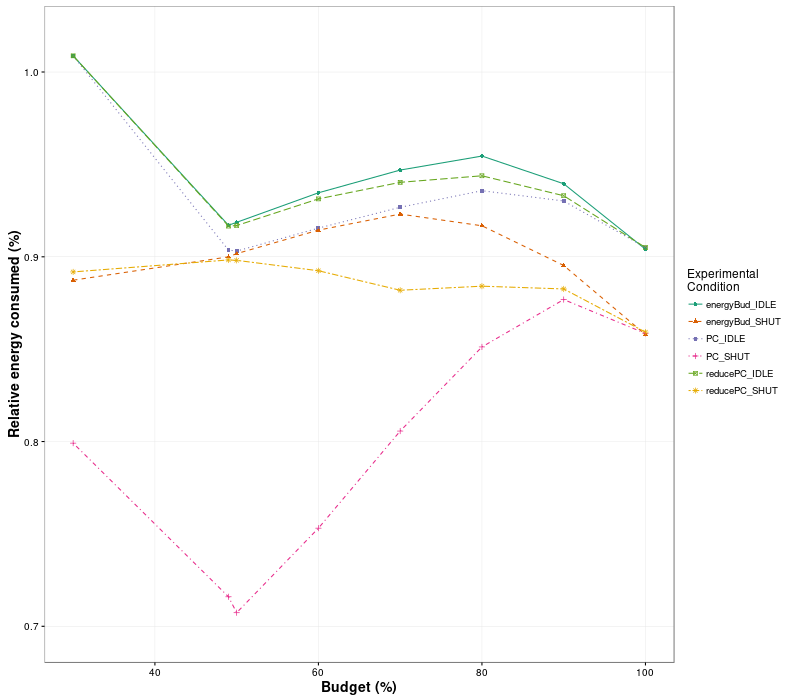

In [17]:

obj = 'eneWCons'

p = ggplot2.ggplot(res[res.cond != "BF_IDLE"]) + \
    ggplot2.aes_string(x='budget_percent', y=obj+"_norm_mean",
                       ymax=obj+"_norm_ciUp", ymin=obj+"_norm_ciDown",
                       color='cond', shape='cond', linetype='cond') + \
    ggplot2.geom_point() + ggplot2.geom_line()+\
    ggplot2.theme_bw()+ggplot2.theme(**theme_bwTUNED)+ggplot2.labs(x="Budget (%)", y="Relative energy consumed (%)")+\
    ggplot2.scale_colour_brewer(name="Experimental\nCondition", palette = "Dark2")+ggplot2.scale_shape(name = "Experimental\nCondition")+\
    ggplot2.scale_linetype_manual(name="Experimental\nCondition",values=robjects.IntVector(range(1,7)))

ggplot_pdf(p, "eneWCons.pdf", 7, 5)
ggplot_notebook(p, height=700)

In [18]:

res2 = res[res.cond != "BF_IDLE"]

res2["shut"] = res2["cond"].apply(lambda x: "SHUT" in x)


dfshut = res2[res2["shut"]]
dfshut = dfshut.sort(["cond", "budget_percent"])

dfidle = res2[res2["shut"]==False]
dfidle = dfidle.sort(["cond", "budget_percent"])
#objectives = ['ctime_mean', 'util_mean', 'avgbsld_mean',
#              'maxbsld_mean', 'energyWeek_mean', 'energyBudget_mean', 'eneWCons_mean', 'jobRunWithEndRel_mean']
objectives = ['ctime_norm_mean', 'util_norm_mean', 'avgbsld_norm_mean',
              'maxbsld_norm_mean', 'energyWeek_norm_mean', 'energyBudget_norm_mean', 'eneWCons_norm_mean', 'jobRunWithEndRel_norm_mean']
accu = {}
for o in objectives:
    for c in dfidle.cond.unique():
        if c not in accu:
            accu[c] = {}
        accu[c][o] = 0.0
for ((i, rshut), (j, ridle)) in zip(dfshut.iterrows(), dfidle.iterrows()):
    assert rshut["cond"][0:2]+str(rshut["budget_percent"]) == ridle["cond"][0:2]+str(ridle["budget_percent"])
    for o in objectives:
        if ridle[o] == 0.0:
            accu[ridle["cond"]][o] = float("Inf")
        else:
            accu[ridle["cond"]][o] += (rshut[o]-ridle[o])/ridle[o]*100.0
    #print rshut["cond"][0:2]+str(rshut["budget_percent"]), " = ", 100 - rshut["energyWeek"]/ridle["energyWeek"]*100


for o in objectives:
    for c in dfidle.cond.unique():
        accu[c][o] = accu[c][o] / len(dfshut)
print(accu)

arr = {}
for o in objectives:
    arr[o] = []

for c in ["PC_IDLE", "reducePC_IDLE", "energyBud_IDLE"]:
    vdict = accu[c]
    print (c)
    for (k,v) in vdict.items():
        arr[k].append(int(v*100)/100.0)
        print( "    "+str(k)+" & "+str( int(v*100)/100.0)+" \\% \\\\")
print (arr)
for (k,v) in arr.items():
    print ("    "+str(k)+" & "+ "  \\% & ".join([str(i) for i in v])+" \\% \\\\")

{'energyBud_IDLE': {'energyWeek_norm_mean': -1.619423302289799, 'util_norm_mean': 5.748355454137989, 'jobRunWithEndRel_norm_mean': 1.4779107065144592, 'energyBudget_norm_mean': -3.718562409766523, 'eneWCons_norm_mean': -1.4250276066725036, 'maxbsld_norm_mean': -5.4402982250098555, 'avgbsld_norm_mean': -8.610859902376864, 'ctime_norm_mean': -1.0099168585076674}, 'reducePC_IDLE': {'energyWeek_norm_mean': -2.1205780487207013, 'util_norm_mean': 4.959153817886223, 'jobRunWithEndRel_norm_mean': 1.406866286100799, 'energyBudget_norm_mean': -5.888592828102858, 'eneWCons_norm_mean': -1.784655819263487, 'maxbsld_norm_mean': -4.383537729639801, 'avgbsld_norm_mean': 0.8824299818702444, 'ctime_norm_mean': -0.7773887444522106}, 'PC_IDLE': {'energyWeek_norm_mean': -5.008263709481927, 'util_norm_mean': -0.05647883848339464, 'jobRunWithEndRel_norm_mean': -0.05498326868832873, 'energyBudget_norm_mean': -17.14680061330449, 'eneWCons_norm_mean': -4.747456481608245, 'maxbsld_norm_mean': 0.0680835144466742,

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


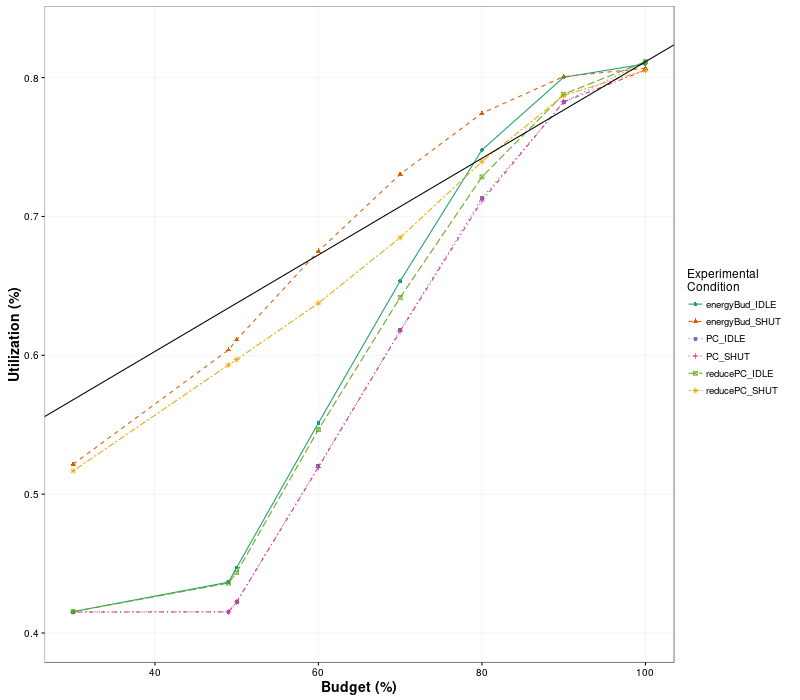

In [19]:

obj = 'util_norm'


easy = res[res.cond == 'BF_IDLE']
#print easy[obj+"_mean"]

#p = ggplot2.ggplot(res[res.budget_percent >=0.5]) + \
p = ggplot2.ggplot(res[res.cond != "BF_IDLE"]) + \
    ggplot2.aes_string(x='budget_percent', y=obj+"_mean", color='cond',
                       ymax=obj+"_ciUp", ymin=obj+"_ciDown", shape='cond', linetype='cond') + \
    ggplot2.geom_point() + ggplot2.geom_line()+\
    ggplot2.geom_abline(intercept=easy[obj+"_mean"]*(4.0/7.0), slope=easy[obj+"_mean"]/100.0*3.0/7.0)+\
    ggplot2.theme_bw()+ggplot2.theme(**theme_bwTUNED)+ggplot2.labs(x="Budget (%)", y="Utilization (%)")+\
    ggplot2.scale_colour_brewer(name="Experimental\nCondition", palette = "Dark2")+ggplot2.scale_shape(name = "Experimental\nCondition")+\
    ggplot2.scale_linetype_manual(name="Experimental\nCondition",values=robjects.IntVector(range(1,7)))
    #ggplot2.geom_errorbar()+

ggplot_pdf(p, "util_p.pdf", 7, 5)
ggplot_notebook(p, height=700)

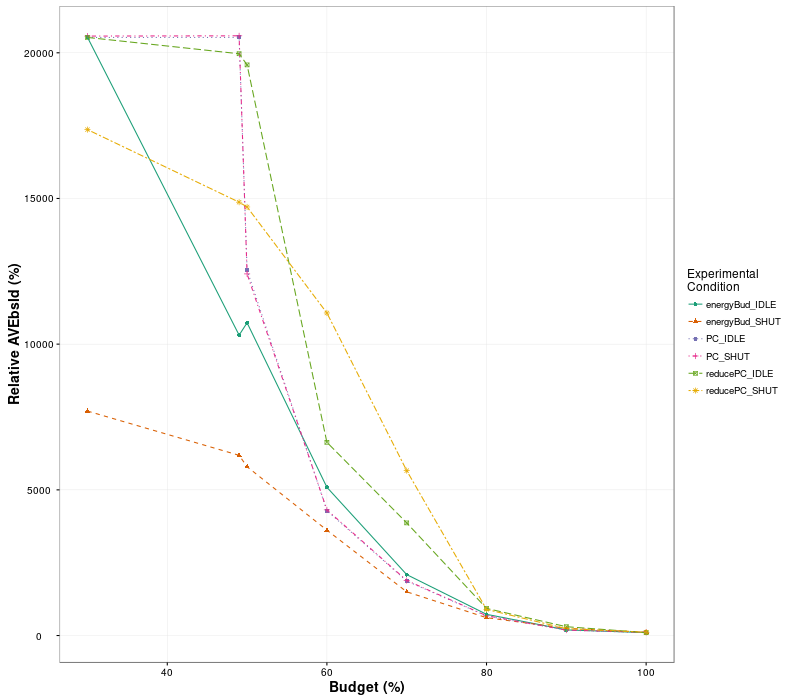

In [20]:
obj = 'avgbsld_p_mean'


#p = ggplot2.ggplot(res[res.budget_percent >=0.9].append(pdab)) + \
p = ggplot2.ggplot(res[res.cond != "BF_IDLE"]) + \
    ggplot2.aes_string(x='budget_percent', y=obj+"*100.0", color='cond', shape='cond', linetype='cond') + \
    ggplot2.geom_point() + ggplot2.geom_line()+\
    ggplot2.theme_bw()+ggplot2.theme(**theme_bwTUNED)+ggplot2.labs(x="Budget (%)", y="Relative AVEbsld (%)")+\
    ggplot2.scale_colour_brewer(name="Experimental\nCondition", palette = "Dark2")+ggplot2.scale_shape(name = "Experimental\nCondition")+\
    ggplot2.scale_linetype_manual(name="Experimental\nCondition",values=robjects.IntVector(range(1,7)))
    

ggplot_pdf(p, "avgbsld_rel_easy.pdf", 7, 5)
ggplot_notebook(p, height=700)

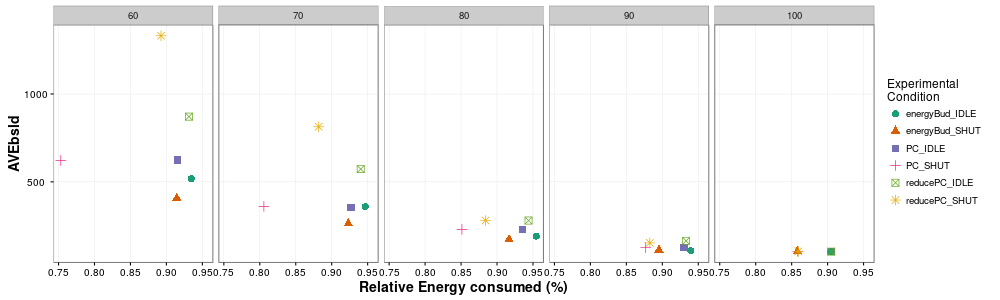

In [21]:

res2 = res[res.cond != "BF_IDLE"]


#p = ggplot2.ggplot(res) + \
p = ggplot2.ggplot(res2[res2.budget_percent >=60]) + \
    ggplot2.aes_string(x='eneWCons_norm_mean', y='util_norm_mean', color='cond', shape='cond') + \
    ggplot2.geom_point(size=3) +\
    ggplot2.facet_grid(ro.Formula('. ~ budget_percent'))+\
    ggplot2.theme_bw()+ggplot2.theme(**theme_bwTUNED)+ggplot2.labs(x="Relative energy consumed (%)", y="Utilization (%)")+\
    ggplot2.scale_colour_brewer(name="Experimental\nCondition", palette = "Dark2")+ggplot2.scale_shape(name = "Experimental\nCondition")

q = ggplot2.ggplot(res2[res2.budget_percent >=60]) + \
    ggplot2.aes_string(x='eneWCons_norm_mean', y='avgbsld_norm_mean', color='cond', shape='cond') + \
    ggplot2.geom_point(size=3) +\
    ggplot2.facet_grid(ro.Formula('. ~ budget_percent'))+\
    ggplot2.theme_bw()+ggplot2.theme(**theme_bwTUNED)+ggplot2.labs(x="Relative Energy consumed (%)", y="AVEbsld")+\
    ggplot2.scale_colour_brewer(name="Experimental\nCondition", palette = "Dark2")+ggplot2.scale_shape(name = "Experimental\nCondition")

ggplot_pdf(p, "eneWConsVSutilp.pdf", 14, 4)
ggplot_pdf(q, "eneWConsVSavgbsld.pdf", 14, 4)
ggplot_notebook(q, height=300, width=1000)

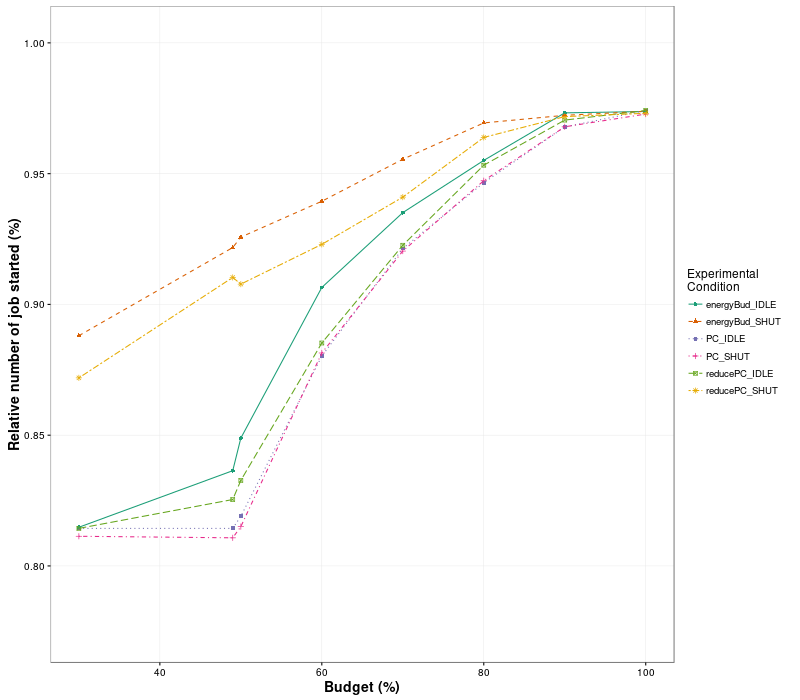

In [22]:
obj = 'jobRunWithEndRel_norm'


p = ggplot2.ggplot(res[res.cond != "BF_IDLE"]) + \
    ggplot2.aes_string(x='budget_percent', y=obj+"_mean",
                       ymax=obj+"_ciUp", ymin=obj+"_ciDown",
                       color='cond', shape='cond', linetype='cond') + \
    ggplot2.geom_point() + ggplot2.geom_line()+ \
    ggplot2.theme_bw()+ggplot2.theme(**theme_bwTUNED)+ggplot2.labs(x="Budget (%)", y="Relative number of job started (%)")+\
    ggplot2.scale_colour_brewer(name="Experimental\nCondition", palette = "Dark2")+ggplot2.scale_shape(name = "Experimental\nCondition")+\
    ggplot2.scale_linetype_manual(name="Experimental\nCondition",values=robjects.IntVector(range(1,7)))
    #ggplot2.geom_errorbar()+
    

ggplot_pdf(p, "jobRunWithEndRel.pdf", 7, 5)
ggplot_notebook(p, height=700)